In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
!pip install tensorflow

  Using cached wheel-0.37.0-py2.py3-none-any.whl (35 kB)
Using legacy 'setup.py install' for wrapt, since package 'wheel' is not installed.
Using legacy 'setup.py install' for clang, since package 'wheel' is not installed.
Using legacy 'setup.py install' for termcolor, since package 'wheel' is not installed.
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
    Running setup.py install for wrapt: started
    Running setup.py install for wrapt: finished with status 'done'
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
    Running setup.py install for clang: started
    Running setup.py install for clang: finished with status 'done'
    Running setup.py install for termcolor: started
    Running setup.py install for termcolor: finished with status 'done'


You should consider upgrading via the 'd:\users\peddi sai varshith\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
#Data Collection and Preprocessing

In [3]:
#Constants

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
#Loading Data Using Tensorflow Data Pipeline

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PLD_3_Classes_256",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4072 files belonging to 3 classes.


Reference Link: https://keras.io/api/preprocessing/image/

In [7]:
#Different types of classes we have

In [8]:
class_names = dataset.class_names
for i,name in enumerate(class_names):
    print(i,":",name)

0 : Early_Blight
1 : Healthy
2 : Late_Blight


In [9]:
print("Total Number of Batches we use are: ",len(dataset))

Total Number of Batches we use are:  128


In [11]:
128*32 #Where the last batch as few images as compared to other batches

4096

In [12]:
#Shape of each batch

In [13]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 2 1 1 2 2 0 2 0 0 1 0 0 2 2 2 2 0 0 1 1 0 1 2 1 2 0 0 0 0]


In [14]:
#Representing one batch images

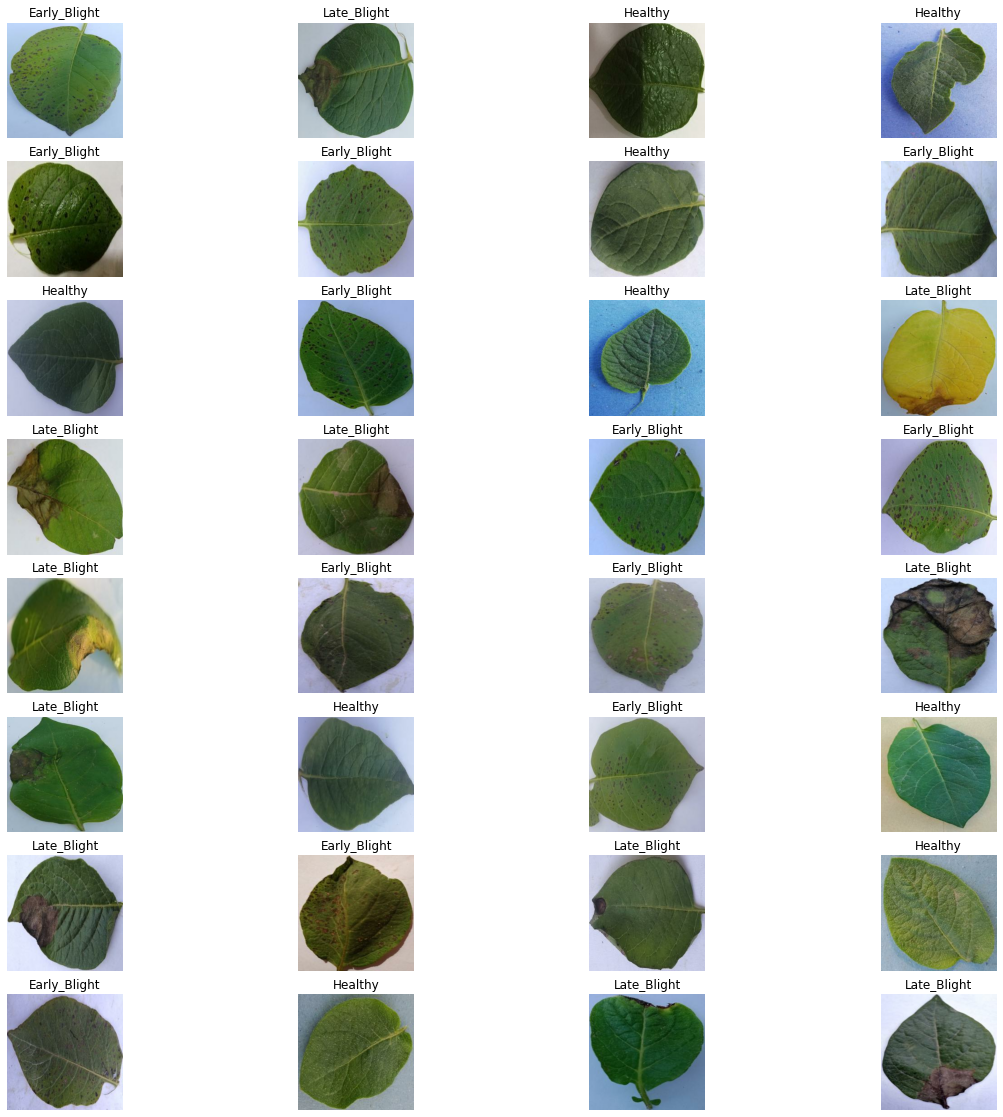

In [15]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")

In [16]:
#Splitting dataset

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    #Number of batches 
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    #Number of training batches
    train_size = int(train_split * ds_size)
    
    #Number of validation batches
    val_size = int(val_split * ds_size)
    
    #Training Dataset
    train_ds = ds.take(train_size)
    
    #Validation Dataset
    val_ds = ds.skip(train_size).take(val_size)
    
    #Test Dataset
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


To Know more about shuffling in Tensorflow Dataset refer: https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset

In [18]:
train_ds,val_ds,test_ds= get_dataset_partitions_tf(dataset)

In [19]:
#Data Size of train,test and validation datasets

In [20]:
print("Training Dataset Size: ",len(train_ds))

Training Dataset Size:  102


In [21]:
print("Validation Dataset Size: ",len(val_ds))

Validation Dataset Size:  12


In [22]:
print("Testing Dataset Size: ",len(test_ds))

Testing Dataset Size:  14


In [23]:
#Optimizing Tensorflow Pipeline Performance

In [24]:
#For Reference 

Preferch: https://www.tensorflow.org/guide/data_performance#prefetching

Cache: https://www.tensorflow.org/guide/data_performance#caching

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [26]:
#Rescaling and Resizing (Preprocessing Layer)

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
#Data Augumentation

Refer: https://keras.io/guides/preprocessing_layers/

In [29]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [30]:
#Model Building

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    #Rescaling and Resizing layer
    resize_and_rescale, 
    
    #Data Augumentation
    data_augumentation, 
    
    #Convolutional layers
    #Relu 
    #Max Pooling
    layers.Conv2D(32, (3,3), activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    #Classification (Flatting)
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [33]:
#Compiling

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
#Training Network

In [36]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
102/102 [==============================] - 238s 2s/step - loss: 1.0194 - accuracy: 0.4787 - val_loss: 0.9438 - val_accuracy: 0.5833
Epoch 2/50
102/102 [==============================] - 189s 2s/step - loss: 0.9031 - accuracy: 0.5923 - val_loss: 0.7414 - val_accuracy: 0.7240
Epoch 3/50
102/102 [==============================] - 177s 2s/step - loss: 0.6568 - accuracy: 0.7509 - val_loss: 0.6833 - val_accuracy: 0.7031
Epoch 4/50
102/102 [==============================] - 175s 2s/step - loss: 0.5514 - accuracy: 0.7870 - val_loss: 0.4947 - val_accuracy: 0.7969
Epoch 5/50
102/102 [==============================] - 175s 2s/step - loss: 0.3668 - accuracy: 0.8630 - val_loss: 0.2751 - val_accuracy: 0.8984
Epoch 6/50
102/102 [==============================] - 176s 2s/step - loss: 0.2635 - accuracy: 0.9049 - val_loss: 0.1972 - val_accuracy: 0.9349
Epoch 7/50
102/102 [==============================] - 176s 2s/step - loss: 0.2496 - accuracy: 0.9154 - val_loss: 0.2645 - val_accuracy: 0.8932

In [37]:
#Evaluation

In [38]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 43s 626ms/step - loss: 0.0405 - accuracy: 0.9844


In [39]:
scores

[0.040485795587301254, 0.984375]

In [40]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 102}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
#Visualization

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

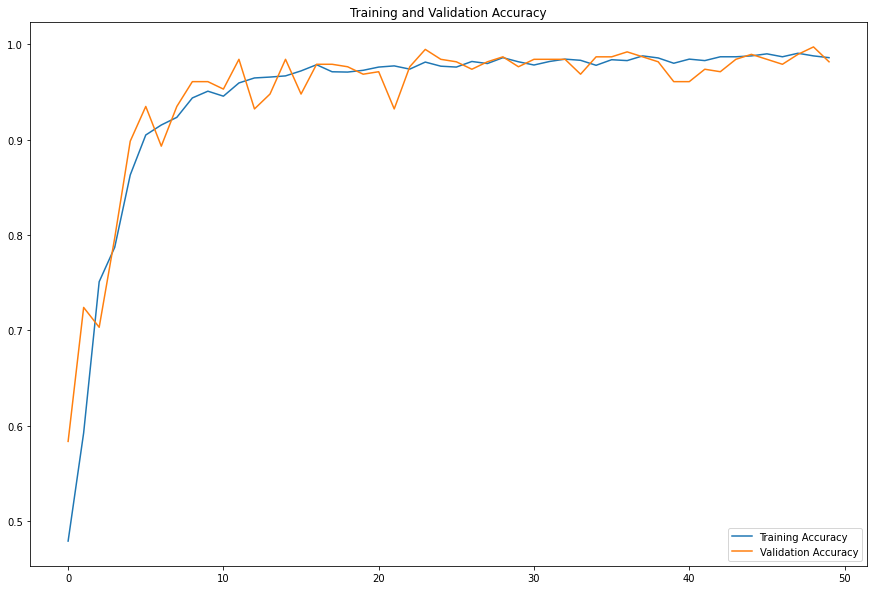

In [44]:
plt.figure(figsize=(15,10))
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

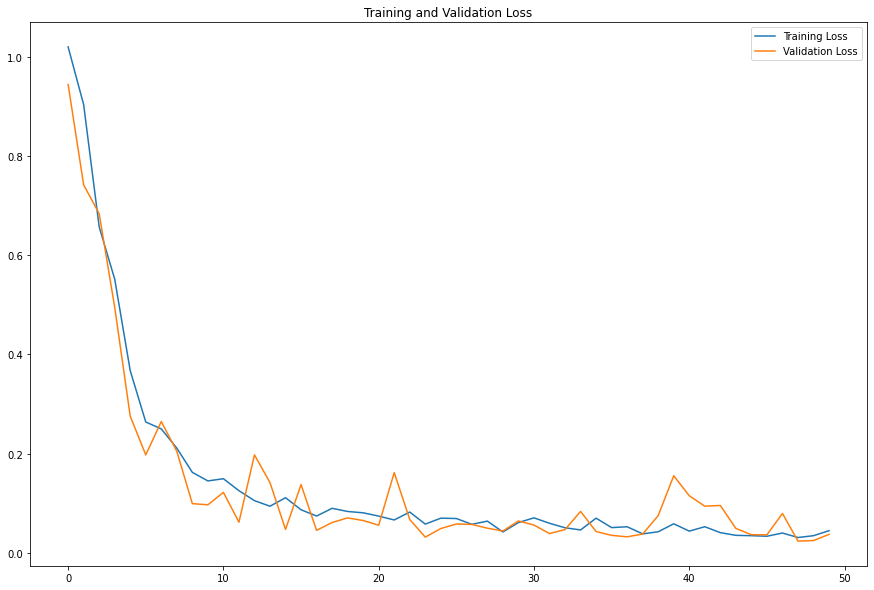

In [45]:
plt.figure(figsize=(15,10))
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [46]:
#Predicting

In [47]:
import numpy as np

first image to predict
actual label: Early_Blight
Predicted label:  Early_Blight


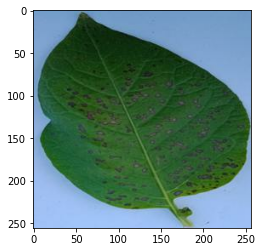

In [48]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label.numpy()])
    
    batch_prediction = model.predict(images_batch)
    #print(batch_prediction[0])
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    
    return predicted_class,confidence

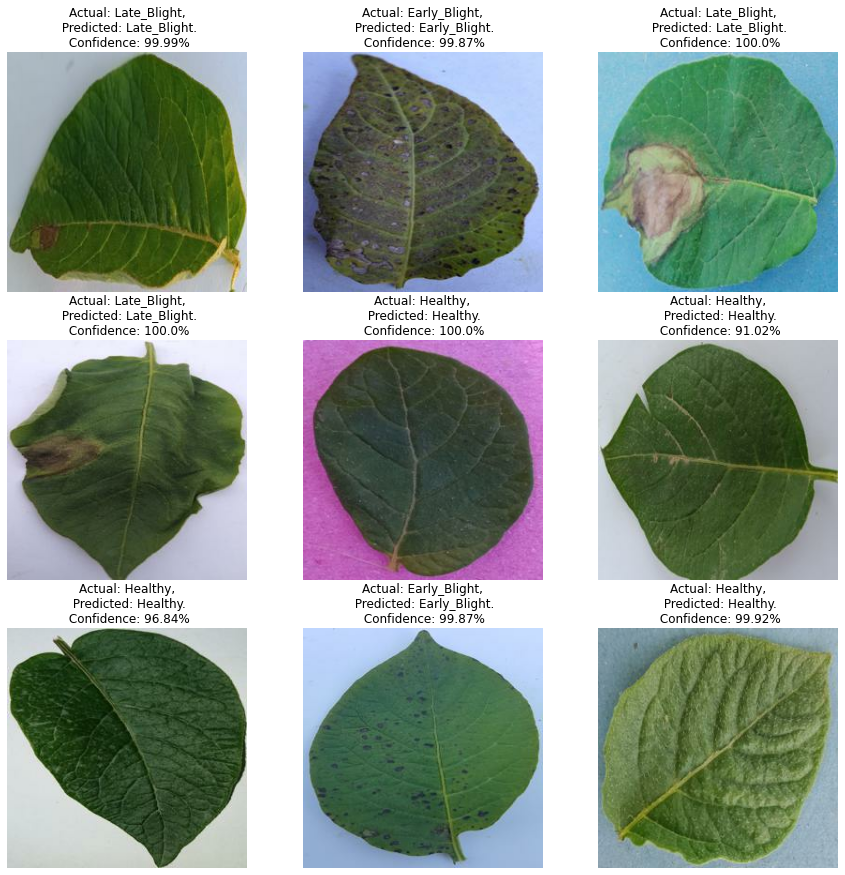

In [50]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax =  plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [63]:
import os
#model_version=max([int(i) for i in os.listdir("../saved_models") + [0]]) +1
model.save("../saved_models/3",save_format="h5")